# Semantic Segmentation of Liver CT Scans with U-Net on the 3Dircadb01 Dataset
In this notebook, we are going to implement a U-Net architecture for liver segmentation. We will tackle this problem in two main parts:

1. 2D U-Net segmentation
    - 1.1 Dataset Building
    - 1.2 Model Creation
    - 1.3 Training and Testing
2. 3D U-Net segmentation


In [1]:
google_colab = True
from pathlib import Path

if google_colab:
    !pip install pydicom
    !pip install -U albumentations
    !pip install opencv-python
    from google.colab import drive
    drive.mount("/content/drive")
    base_path = Path("/content/drive/MyDrive")
else:
    base_path = Path("C:/Users/HP/Desktop/PIMA")

!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [2]:
import torch
import torch.nn as nn # neural networks functions
import torch.optim as optim # optimizer
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as tf
from torchvision.datasets import ImageFolder
#import timm # specific for image classification tasks

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from PIL import Image
from pydicom import dcmread
import albumentations as A # image augmentation library
from pathlib import Path
import os
import cv2
from tqdm import tqdm

print(f'System version: {sys.version}')
print(f'PyTorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

System version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
NumPy version: 2.0.2
Pandas version: 2.2.2


# Optional:
For a better comprehension and a better visualization of the data, we unzip the `PATIENT_DICOM`, `MASKS_DICOM` and `LABELLED_DICOM` folders and convert the DICOM files into png or jpeg. In the `convert_folder` and the `dicom_to_png_jpeg` functions, you can specify which format you prefer.

There are 20 patients in the IRCAD dataset so we run the below code for each patient

In [3]:
# converting and saving the png/jpeg, not adapted for google colab (for now)
#from utils import unzip, convert_folder, create_data_folder
import zipfile
def unzip(zip_path, extract_path):
    """
    Extracts the compressed zip folder zip_path
    in the extract_path. If the extract_path folder
    doesn't exist already, it is created before the
    extraction.
    """
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"{zip_path} is extracted to: {extract_path}")
    return

unzip(zip_path=base_path/"3Dircadb1.zip", extract_path=base_path)

for i in range(1, 21):
        current = f"3Dircadb1/3Dircadb1.{i}"
        unzip(zip_path=base_path/current/"MASKS_DICOM.zip", extract_path=base_path/current/"MASKS_DICOM")
        #convert_folder(dicom_dir=base_path/current/"MASKS_DICOM/MASKS_DICOM/liver", output_dir=base_path/current/"MASKS_DICOM"/"converted", patient_num=i, jpg=False, verbose=False, preprocess=False)
        unzip(zip_path=base_path/current/"PATIENT_DICOM.zip", extract_path=base_path/current/"PATIENT_DICOM")
        #convert_folder(dicom_dir=base_path/current/"PATIENT_DICOM/PATIENT_DICOM", output_dir=base_path/current/"PATIENT_DICOM/converted", patient_num=i, jpg=False, verbose=False, preprocess=False)
        #unzip(zip_path=base_path/current/"LABELLED_DICOM.zip", extract_path=base_path/current/"LABELLED_DICOM")
        #convert_folder(dicom_dir=base_path/current/"LABELLED_DICOM/LABELLED_DICOM", output_dir=base_path/current/"LABELLED_DICOM/converted", patient_num=i, jpg=False, verbose=False, preprocess=False)

# create_data_folder(base_path=base_path)
# create_data_folder(base_path=base_path, preprocess=True)

/content/drive/MyDrive/3Dircadb1.zip is extracted to: /content/drive/MyDrive
/content/drive/MyDrive/3Dircadb1/3Dircadb1.1/MASKS_DICOM.zip is extracted to: /content/drive/MyDrive/3Dircadb1/3Dircadb1.1/MASKS_DICOM
/content/drive/MyDrive/3Dircadb1/3Dircadb1.1/PATIENT_DICOM.zip is extracted to: /content/drive/MyDrive/3Dircadb1/3Dircadb1.1/PATIENT_DICOM
/content/drive/MyDrive/3Dircadb1/3Dircadb1.2/MASKS_DICOM.zip is extracted to: /content/drive/MyDrive/3Dircadb1/3Dircadb1.2/MASKS_DICOM
/content/drive/MyDrive/3Dircadb1/3Dircadb1.2/PATIENT_DICOM.zip is extracted to: /content/drive/MyDrive/3Dircadb1/3Dircadb1.2/PATIENT_DICOM
/content/drive/MyDrive/3Dircadb1/3Dircadb1.3/MASKS_DICOM.zip is extracted to: /content/drive/MyDrive/3Dircadb1/3Dircadb1.3/MASKS_DICOM
/content/drive/MyDrive/3Dircadb1/3Dircadb1.3/PATIENT_DICOM.zip is extracted to: /content/drive/MyDrive/3Dircadb1/3Dircadb1.3/PATIENT_DICOM
/content/drive/MyDrive/3Dircadb1/3Dircadb1.4/MASKS_DICOM.zip is extracted to: /content/drive/MyDrive/


| #  | 1st liver appearance | Last liver appearance | Total number of slices in between | Total patient slices |
|----|----------------------|-----------------------|-----------------------------------|----------------------|
| 1  | image_27             | image_124             | 98                                | 129                  |
| 2  | image_44             | image_157             | 114                               | 172                  |
| 3  | image_61             | image_182             | 122                               | 200                  |
| 4  | image_19             | image_85              | 67                                | 91                   |
| 5  | image_19             | image_137             | 119                               | 139                  |
| 6  | image_37             | image_132             | 96                                | 135                  |
| 7  | image_48             | image_145             | 98                                | 151                  |
| 8  | image_6              | image_121             | 116                               | 124                  |
| 9  | image_11             | image_99              | 89                                | 111                  |
| 10 | image_22             | image_120             | 99                                | 122                  |
| 11 | image_33             | image_128             | 96                                | 132                  |
| 12 | image_9              | image_247             | 239                               | 260                  |
| 13 | image_26             | image_115             | 90                                | 122                  |
| 14 | image_4              | image_107             | 104                               | 113                  |
| 15 | image_6              | image_120             | 115                               | 125                  |
| 16 | image_39             | image_151             | 113                               | 155                  |
| 17 | image_1              | image_113             | 113                               | 119                  |
| 18 | image_12             | image_70              | 59                                | 74                   |
| 19 | image_28             | image_68              | 41                                | 124                  |
| 20 | image_126            | image_210             | 85                                | 225                  |
total | | | 2073 | 2823


2,12,18,20 were all black before normalization.

[0]
[0 1]
[0 1]
[0]


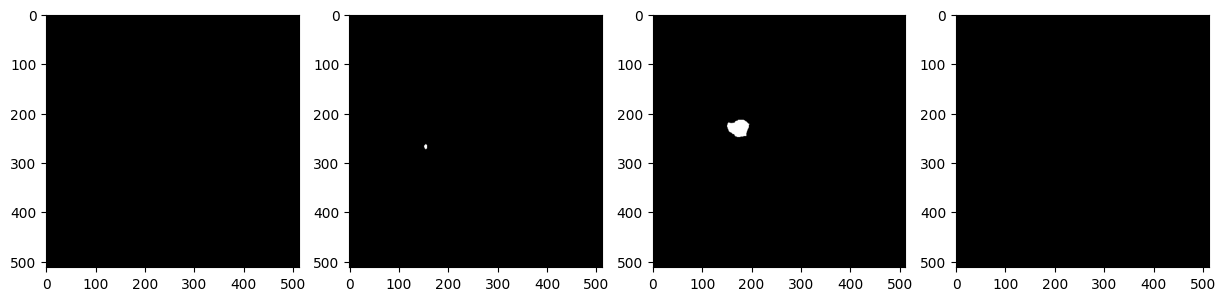

In [ ]:
# why some masks contain 0-1 values while some others contain 0-255?
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 8))
tmp=dcmread(base_path/"3Dircadb1/3Dircadb1.2/MASKS_DICOM/MASKS_DICOM/liver/image_1").pixel_array
ax[0].imshow(tmp, cmap="gray")
print(np.unique(tmp))
tmp = dcmread(base_path/"3Dircadb1/3Dircadb1.2/MASKS_DICOM/MASKS_DICOM/liver/image_44").pixel_array
ax[1].imshow(tmp, cmap="gray")
print(np.unique(tmp))
tmp = dcmread(base_path/"3Dircadb1/3Dircadb1.2/MASKS_DICOM/MASKS_DICOM/liver/image_157").pixel_array
ax[2].imshow(tmp, cmap="gray")
print(np.unique(tmp))
tmp = dcmread(base_path/"3Dircadb1/3Dircadb1.2/MASKS_DICOM/MASKS_DICOM/liver/image_171").pixel_array
ax[3].imshow(tmp, cmap="gray")
print(np.unique(tmp))

## 1.1 Dataset Building
We perform a HU clipping for a better liver visualization. Holder et al. decided that the interval [-200, 200] was better suited for liver segmentation. What about -100, 400? We compare these two different HU clippings in this part.

Use image windowing to increase the contrast across a region of interest. => Masoudi et al., "Quick guide on radiology image pre-processing for deep learning applications in prostate cancer research".

In [ ]:
# function to compare different HU clippings, not adapted for google colab (for now)
from utils import dicom_preprocess

def comparison_visualize(num_patient, num_slice):

    dicom_image = dcmread(base_path/f"3Dircadb1/3Dircadb1.{num_patient}/PATIENT_DICOM/PATIENT_DICOM/image_{num_slice}").pixel_array
    plt.hist(dicom_image.flatten())
    plt.xticks([-1000, -500, -200, 0, 200, 500, 1000])

    fig, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
    ax[0,0].imshow(np.array(Image.open(base_path/f"3Dircadb1/3Dircadb1.{num_patient}/PATIENT_DICOM/converted/image_{num_patient}_{num_slice}.png")), cmap="gray")
    ax[0,0].axis("off")
    ax[0,0].set_title("original")

    tmp = dicom_preprocess(base_path/f"3Dircadb1/3Dircadb1.{num_patient}/PATIENT_DICOM/PATIENT_DICOM/image_{num_slice}")
    ax[0,1].imshow(tmp, vmin=tmp.min(), vmax=tmp.max(), cmap="gray")
    ax[0,1].axis("off")
    ax[0,1].set_title("[-100, 400] non normalisé")

    ax[0,2].imshow(tmp, cmap="gray")
    ax[0,2].axis("off")
    ax[0,2].set_title("[-100, 400] normalisé")

    ax[1,0].imshow(dcmread(base_path/f"3Dircadb1/3Dircadb1.{num_patient}/MASKS_DICOM/MASKS_DICOM/liver/image_{num_slice}").pixel_array, cmap='gray')
    ax[1,0].axis("off")
    ax[1,0].set_title("mask")

    tmp = dicom_preprocess(base_path/f"3Dircadb1/3Dircadb1.{num_patient}/PATIENT_DICOM/PATIENT_DICOM/image_{num_slice}", min_hu=-200, max_hu=200)
    ax[1,1].imshow(tmp, vmin=tmp.min(), vmax=tmp.max(), cmap="gray")
    ax[1,1].axis("off")
    ax[1,1].set_title("[-200, 200] non normalisé")

    ax[1,2].imshow(tmp, cmap="gray")
    ax[1,2].axis("off")
    ax[1,2].set_title("[-200, 200] normalisé")

    # mask values
    print(f"mask values: {np.unique(dcmread(base_path/f'3Dircadb1/3Dircadb1.{num_patient}/MASKS_DICOM/MASKS_DICOM/liver/image_{num_slice}').pixel_array)}")

    dcm = dcmread(base_path/f"3Dircadb1/3Dircadb1.{num_patient}/PATIENT_DICOM/PATIENT_DICOM/image_{num_slice}")
    print(f"WindowCenter: {getattr(dcm, 'WindowCenter')}")

    dcm = dcm.pixel_array
    print(f"dicom min: {dcm.min()} and max: {dcm.max()}")

mask values: [0 1]
WindowCenter: 0
dicom min: -1024 and max: 1023


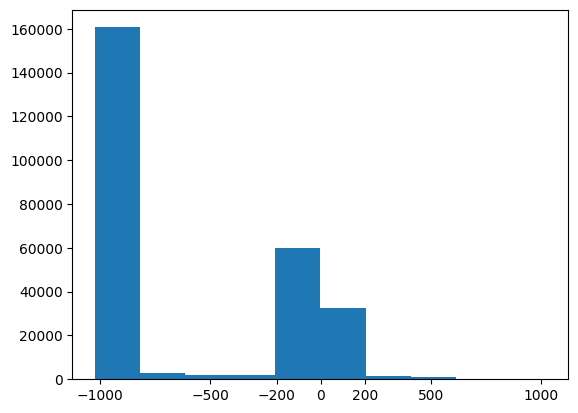

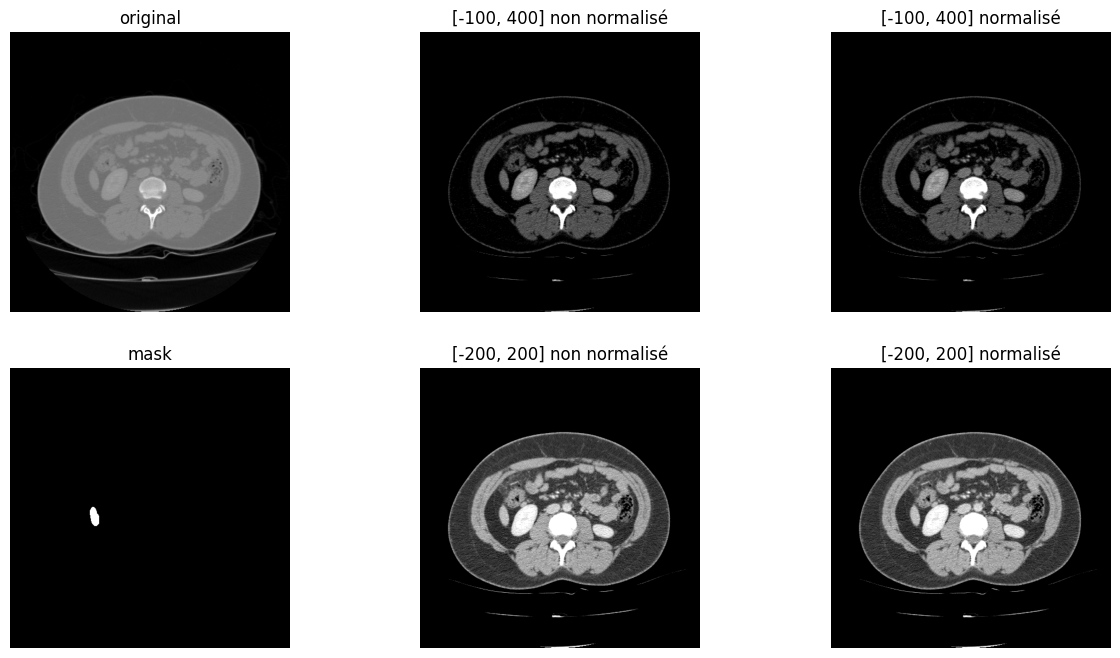

In [ ]:
comparison_visualize(num_patient=2, num_slice=47)

mask values: [  0 255]
WindowCenter: 0
dicom min: -1024 and max: 3071


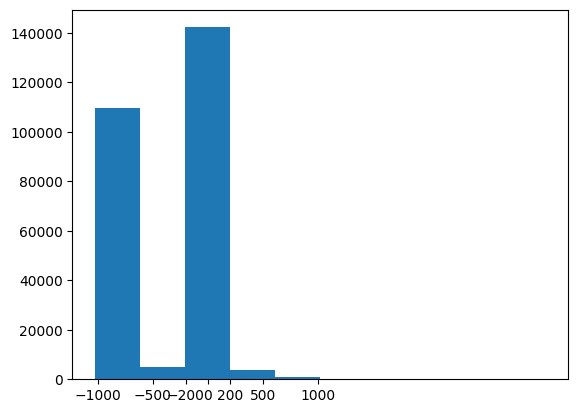

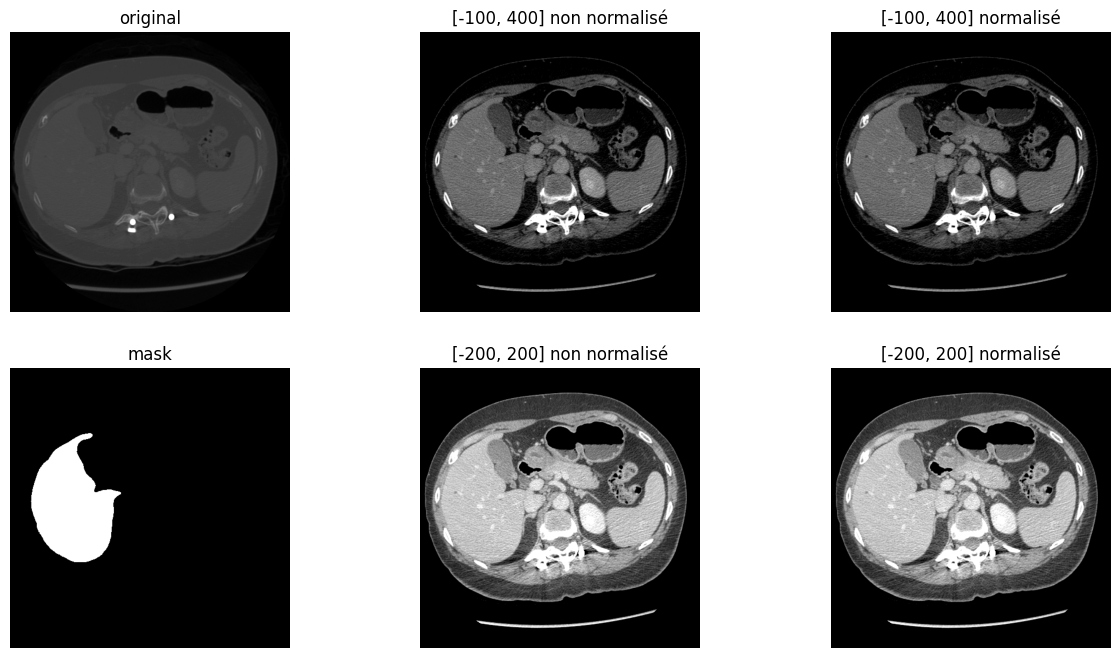

In [ ]:
comparison_visualize(num_patient=3, num_slice=114)

mask values: [  0 255]
WindowCenter: 0
dicom min: -2048 and max: 1198


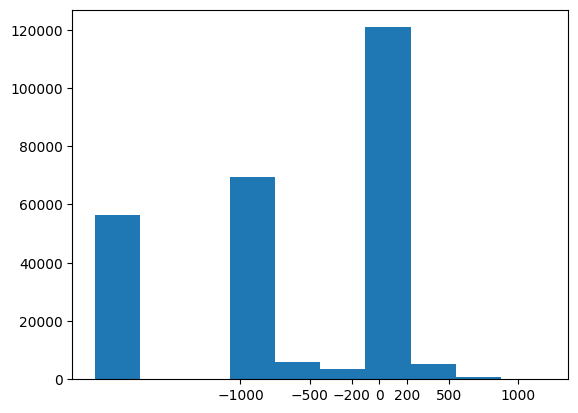

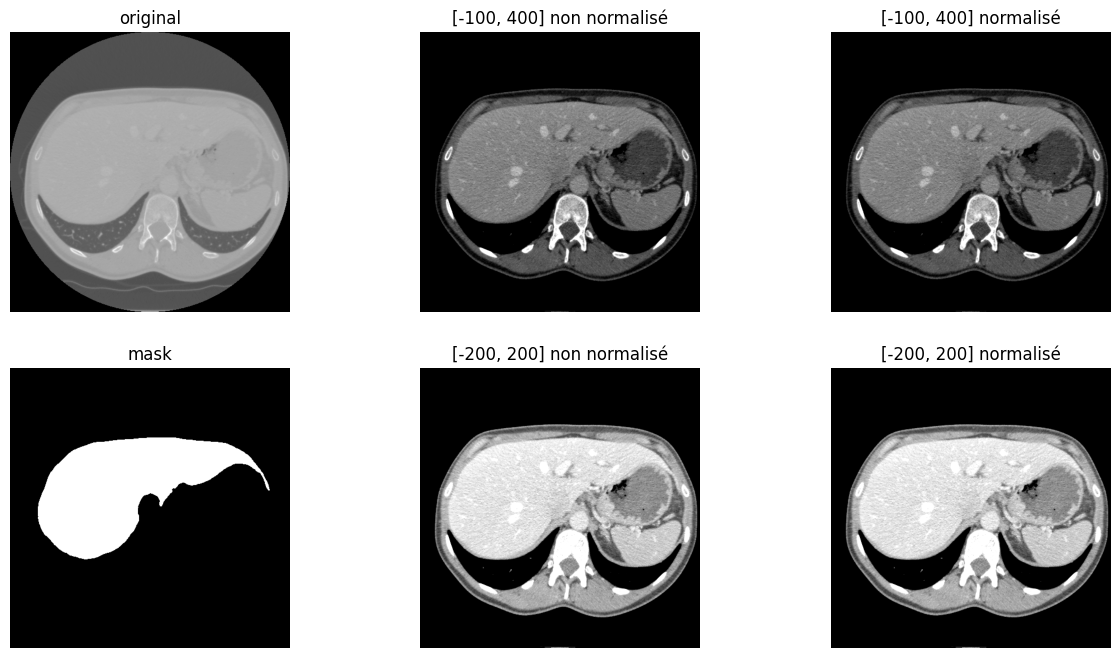

In [ ]:
comparison_visualize(num_patient=8, num_slice=88)

Seems like $[-100, 400]$ is a better fit.

Data Augmentation => builds a bigger dataset and invariance

For this use case and this dataset, we need elastic deformations and shift? Which data augmentation pipeline is better suited for the case of a patient moving during the CT scans?

In [17]:
# Define augmentation pipeline

p = 0.95
# horizontalFlip???
train_transform = A.Compose([
        A.Affine(
            scale=(0.9, 1.1),
            translate_percent={"x": 0.0625, "y": 0.0625},
            rotate=(-45, 45),
            shear={"x": (-5, 5), "y": (-5, 5)},
            p=p
        ),
        A.RandomBrightnessContrast(p=p, brightness_limit=0.15, contrast_limit=0.15),
        A.Resize(572, 572),
    ])

Text(0.5, 1.0, 'image with mask')

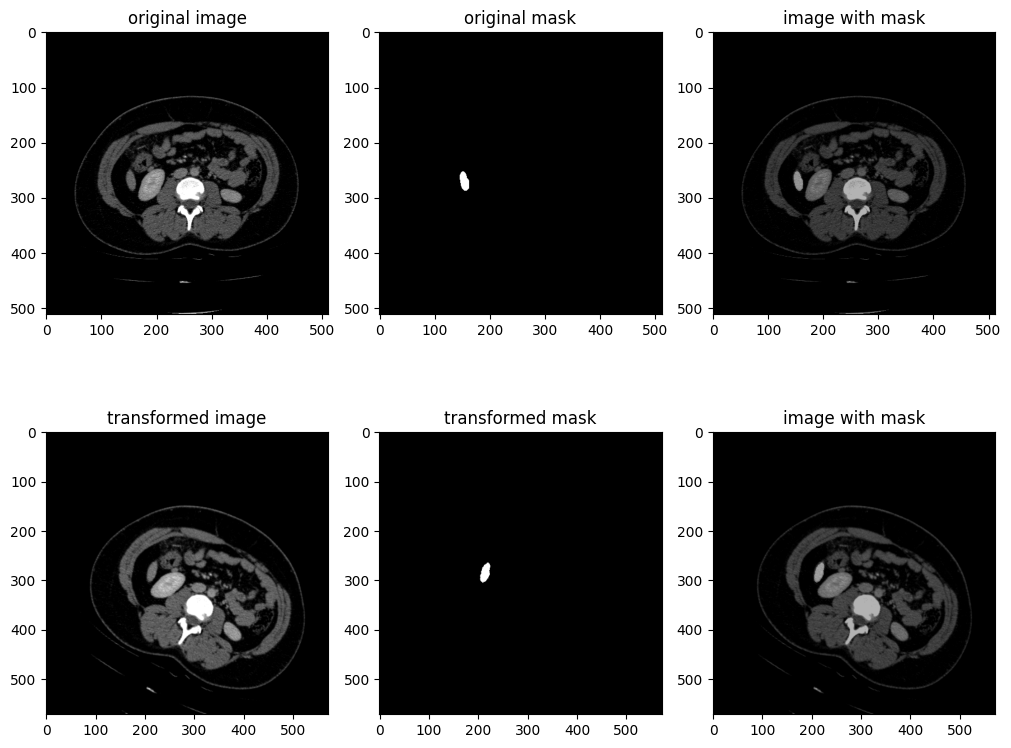

In [ ]:
# not adapted for google colab (for now)

img = cv2.imread(base_path/"Data/Preprocessed/Images/image_2_47.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(base_path/"Data/Preprocessed/Masks/image_2_47.png", cv2.IMREAD_GRAYSCALE)

aug = train_transform(image=img, mask=mask)
img_t = aug["image"]
mask_t = aug["mask"]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,8), constrained_layout=True)

ax[0, 0].imshow(img, cmap="gray", interpolation=None)
ax[0, 0].set_title("original image")

ax[0, 1].imshow(mask, cmap="gray", interpolation=None)
ax[0, 1].set_title("original mask")

ax[0, 2].imshow(img, cmap="gray", interpolation=None)
ax[0, 2].imshow(mask, cmap="gray", interpolation=None, alpha=0.3)
ax[0, 2].set_title("image with mask")

ax[1, 0].imshow(img_t, cmap="gray", interpolation=None)
ax[1, 0].set_title("transformed image")

ax[1, 1].imshow(mask_t, cmap="gray", interpolation=None)
ax[1, 1].set_title("transformed mask")

ax[1, 2].imshow(img_t, cmap="gray", interpolation=None)
ax[1, 2].imshow(mask_t, cmap="gray", interpolation=None, alpha=0.3)
ax[1, 2].set_title("image with mask")


Next we need to define the dataset class. You can find the code in the `LiverCTDataset.py` file.

In [3]:
# LiverCTDataset.py
#from utils import dicom_preprocess

def dicom_preprocess(path, min_hu=-100, max_hu=400):
    """
    Performs preprocessing on the DICOM image located at path.
    """
    dcm_file = dcmread(path)

    pixel_data = dcm_file.pixel_array.astype(np.float32)

    # HU conversion
    slope = getattr(dcm_file, "RescaleSlope", 1.0)
    intercept = getattr(dcm_file, "RescaleIntercept", 0.0)
    pixel_hu = pixel_data * slope + intercept

    # HU clipping, d'après Halder et al. il faut qu'il soit entre [-200,200] pour la tâche de la segmentation du foie
    pixel_clipped = np.clip(pixel_hu, min_hu, max_hu)
    return pixel_clipped

class LiverCTDataset(Dataset):

    def __init__(self, images: list, masks: list, transform=None, showHisto=False, dicom=True, min_hu=-100, max_hu=400):
        self.images = images
        self.masks = masks

        self.transform = transform

        self.images_dtype = torch.float32
        self.masks_dtype = torch.float32

        self.showHisto = showHisto
        self.dicom = dicom
        self.min_hu = min_hu
        self.max_hu = max_hu

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index: int):
        image_ID = self.images[index]
        mask_ID = self.masks[index]

        print("Loading the following image, mask")
        print(image_ID)
        print(mask_ID)

        if self.dicom:
            image = dicom_preprocess(image_ID, min_hu=self.min_hu, max_hu=self.max_hu)
            image = (image - self.min_hu)/(self.max_hu - self.min_hu)
            image = np.expand_dims(image, -1)
            image = image.astype(np.float32)

            mask = dcmread(mask_ID).pixel_array
            mask = (mask > 0).astype(np.float32)
            mask = np.expand_dims(mask, -1)
            mask = mask.astype(np.float32)

        else:
            image = cv2.imread(image_ID, cv2.IMREAD_GRAYSCALE)
            image = image/255.
            image = np.expand_dims(image, -1)
            image = image.astype(np.float32)

            mask = cv2.imread(mask_ID, cv2.IMREAD_GRAYSCALE)
            mask = mask/255.
            mask = np.expand_dims(mask, -1)
            mask = mask.astype(np.float32)

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image, mask = torch.from_numpy(image).type(self.images_dtype), torch.from_numpy(mask).type(self.masks_dtype)
        image, mask = image.permute(2, 0, 1), mask.permute(2, 0, 1)

        if self.showHisto:
            plt.title(f"histogram for {os.path.splitext(image_ID)[0]}:")
            plt.hist(image.flatten())
            plt.xticks([-1000, -500, -200, 0, 200, 500, 1000])
            plt.show()

        return image, mask

Now we put it all together:

In [ ]:
from utils import load_all_liver_appearances

images, masks = load_all_liver_appearances(base_path=base_path)

training_dataset = LiverCTDataset(images=images,
                           masks=masks,
                           transform=train_transform,
                           showHisto=False)

training_dataloader = DataLoader(dataset=training_dataset,
                                      batch_size=2,
                                      shuffle=True)

image, mask = next(iter(training_dataloader))

print(f'image = shape: {image.shape}, type: {image.dtype}')
print(f'image = min: {image.min()}, max: {image.max()}')
print(f'mask = shape: {mask.shape}, class: {mask.unique()}, type: {mask.dtype}')
print(len(training_dataset))
print(len(training_dataloader))


C:\Users\HP\Desktop\PIMA\3Dircadb1\3Dircadb1.17\PATIENT_DICOM\PATIENT_DICOM\image_46
C:\Users\HP\Desktop\PIMA\3Dircadb1\3Dircadb1.17\MASKS_DICOM\MASKS_DICOM\liver\image_46
inja [0. 1.]
C:\Users\HP\Desktop\PIMA\3Dircadb1\3Dircadb1.1\PATIENT_DICOM\PATIENT_DICOM\image_75
C:\Users\HP\Desktop\PIMA\3Dircadb1\3Dircadb1.1\MASKS_DICOM\MASKS_DICOM\liver\image_75
inja [0. 1.]
image = shape: torch.Size([2, 1, 572, 572]), type: torch.float32
image = min: 0.0, max: 1.0
mask = shape: torch.Size([2, 1, 572, 572]), class: tensor([0., 1.]), type: torch.float32
2073
1037


## 1.2 Model Creation

For a better visualization of the different parts of the model, each part is set in a different file so you can find the different bits of the model in `double_conv.py`, `encoder.py` and `decoder.py`.

In [4]:
# double_conv.py

class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [5]:
# encoder.py


class Encoder(nn.Module):

    def __init__(self, in_channels=1, channels=(64, 128, 256, 512)):
        # in_channel=1 for grayscale, 3 for RGB
        super(Encoder, self).__init__()
        self.down = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for channel in channels:
            self.down.append(DoubleConv(in_channels, channel))
            in_channels = channel

        self.bottleneck = DoubleConv(channels[-1], channels[-1]*2)

    def forward(self, x):
        skip_connections = []

        for down in self.down:
            x = down(x)
            # skip connections store the feature maps from each level before they get downsampled
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        return x, skip_connections

In [6]:
# decoder.py
class Decoder(nn.Module):

    def __init__(self, out_channel=1, channels=(512, 256, 128, 64)):
        super(Decoder, self).__init__()

        self.up = nn.ModuleList()

        for channel in channels:
            # upsampling convolution
            self.up.append(
                nn.ConvTranspose2d(in_channels=channel * 2, out_channels=channel, kernel_size=2, stride=2)
            )
            self.up.append(DoubleConv(channel * 2, channel))

        self.final_conv = nn.Conv2d(channels[-1], out_channel, kernel_size=1)

    def forward(self, x):
        out, skip_connections = x

        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.up), 2):
            out = self.up[i](out)
            skip_connection = skip_connections[i//2] # can't do i-1 because of index 0

            # avoids problems arising from the difference of size
            if out.shape != skip_connection:
                out = tf.resize(out, size=skip_connection.shape[2:])

            concat = torch.cat((skip_connection, out), dim=1)

            out = self.up[i+1](concat)

        return self.final_conv(out)

The assembled U-Net model will be the following:

In [7]:
# unet.py

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder(channels=(64, 128))
        self.decoder = Decoder(channels=(128, 64))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## 1.3 Training and Testing


In order to be able to perform the training we need to define the loss function we are going to use. In this case, we decided to use the Dice Loss. The implementation is located in the `loss.py` file. The implementation follows this formula:

$$Dice = \frac{2\sum(Prediction\times Ground Truth)}{\sum Prediction + \sum Ground Truth}$$

For probabilistic annotations (e.g. 0 to 255 values), the Squared Dice Loss is more adapted:
$$Dice = \frac{2\sum(Prediction\times Ground Truth)}{\sum Prediction^2+ \sum Ground Truth^2}$$

In our case, we have annotation masks with 0 and 1 values so the Dice Loss is the one we are going to use.

In [8]:
# loss.py

def dice_metric(pred, gt_mask, eps=1): # plus haut => meilleur
    pred = torch.sigmoid(pred)
    intersection = (pred * gt_mask).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + gt_mask.sum(dim=(2, 3))
    union = torch.where(union == 0, union + eps, union)
    dice_coeff = (2. * intersection) / union
    return dice_coeff

def dice_loss(pred, gt_mask, eps=1): # plus bas => meilleur
    dice_coeff = dice_metric(pred=pred, gt_mask=gt_mask, eps=eps)
    return 1 - dice_coeff.mean()

In [9]:
# Hyperparameters
LEARNING_RATE = 1e-4 # should conduct an experiment to determine the best value for this task
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
BATCH_SIZE = 3 # Rule of thumb: start batch_size = 4 or 8 and increase it until you run out of GPU memory
NUM_EPOCHS = 1
NUM_WORKERS = 2 #  Rule of thumb: num_workers = number of CPU cores // 2, in my case 10 cores
IMG_H = 572
IMG_W = 572

print(f"Learning Rate: {LEARNING_RATE}")
print(f"Device: {DEVICE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Workers: {NUM_WORKERS}")
print(f"Image height and width: {IMG_H}, {IMG_W}")

cuda
Learning Rate: 0.0001
Device: cuda
Batch Size: 3
Epochs: 1
Workers: 2
Image height and width: 572, 572


In [10]:
LIVER_INDICES = {1:  (27 , 124),
                 2:  (44 , 157),
                 3:  (61 , 182),
                 4:  (19 , 85 ),
                 5:  (19 , 137),
                 6:  (37 , 132),
                 7:  (48 , 145),
                 8:  (6  , 121),
                 9:  (11 , 99 ),
                 10: (22 , 120),
                 11: (33 , 128),
                 12: (9  , 247),
                 13: (26 , 115),
                 14: (4  , 107),
                 15: (6  , 120),
                 16: (39 , 151),
                 17: (1  , 113),
                 18: (12 , 70 ),
                 19: (28 , 68 ),
                 20: (126, 210),
            }


# Load all the liver present dicom pathes from the dataset -------------------------------------------
def load_all_liver_appearances(base_path:Path, num_patients=[]):
    global LIVER_INDICES
    images, masks = [], []

    to_load = LIVER_INDICES.keys() if num_patients == [] else num_patients

    for num_patient in to_load:
        first, last = LIVER_INDICES[num_patient]
        for ind in range(first, last+1):
            images.append(base_path/f"3Dircadb1/3Dircadb1.{num_patient}/PATIENT_DICOM/PATIENT_DICOM/image_{ind}")
            masks.append(base_path/f"3Dircadb1/3Dircadb1.{num_patient}/MASKS_DICOM/MASKS_DICOM/liver/image_{ind}")

    return images, masks


train_images, train_masks = load_all_liver_appearances(base_path=base_path, num_patients=list(range(1,19)))
test_images, test_masks = load_all_liver_appearances(base_path=base_path, num_patients=list(range(19,21)))
p = 0.95
training_dataset = LiverCTDataset(images=train_images,
                           masks=train_masks,
                           transform=A.Compose([
                                  A.Affine(
                                      scale=(0.9, 1.1),
                                      translate_percent={"x": 0.0625, "y": 0.0625},
                                      rotate=(-45, 45),
                                      shear={"x": (-5, 5), "y": (-5, 5)},
                                      p=p
                                  ),
                                  A.RandomBrightnessContrast(p=p, brightness_limit=0.15, contrast_limit=0.15),
                                  A.Resize(IMG_H, IMG_W),
                              ]),
                           showHisto=False)

training_dataloader = DataLoader(dataset=training_dataset,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=True)

testing_dataset = LiverCTDataset(images=test_images,
                           masks=test_masks,
                           transform=A.Compose([
                                      A.Resize(IMG_H, IMG_W)
                                    ]),
                           showHisto=False)

testing_dataloader = DataLoader(dataset=testing_dataset,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=False)

assert len(training_dataset) + len(testing_dataset) == 2073

print("Loading first batch...")
first_batch = next(iter(training_dataloader))
first_batch = next(iter(testing_dataloader))
print("First batch loaded.")

Loading first batch...
Loading the following image, maskLoading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.17/PATIENT_DICOM/PATIENT_DICOM/image_112
/content/drive/MyDrive/3Dircadb1/3Dircadb1.17/MASKS_DICOM/MASKS_DICOM/liver/image_112

/content/drive/MyDrive/3Dircadb1/3Dircadb1.7/PATIENT_DICOM/PATIENT_DICOM/image_68
/content/drive/MyDrive/3Dircadb1/3Dircadb1.7/MASKS_DICOM/MASKS_DICOM/liver/image_68
Loading the following image, maskLoading the following image, mask

/content/drive/MyDrive/3Dircadb1/3Dircadb1.10/PATIENT_DICOM/PATIENT_DICOM/image_39/content/drive/MyDrive/3Dircadb1/3Dircadb1.11/PATIENT_DICOM/PATIENT_DICOM/image_62

/content/drive/MyDrive/3Dircadb1/3Dircadb1.11/MASKS_DICOM/MASKS_DICOM/liver/image_62/content/drive/MyDrive/3Dircadb1/3Dircadb1.10/MASKS_DICOM/MASKS_DICOM/liver/image_39

Loading the following image, maskLoading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.6/PATIENT_DICOM/PATIENT_DICOM/image_115

/content/drive/MyD

In [14]:
# initialization of the training process
# BATCH SIZE = 3
model = UNet().to(device=DEVICE)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE) # SGD?
loss_func = dice_loss
metric_func = dice_metric

train_loss_all, test_loss_all = [], [] # mean loss per EPOCH
train_metric_all, test_metric_all = [], []

for ep in tqdm(range(NUM_EPOCHS)):
    print("epoch")
    model.train()
    print("train")
    step = 0
    current_train_loss = 0
    current_train_metric = 0

    # training loop
    for i, batch in enumerate(training_dataloader):
        print(f"training loop num {i}")
        image_tmp, mask_tmp = batch
        image, mask = image_tmp.to(device=DEVICE), mask_tmp.to(device=DEVICE)

        optimizer.zero_grad()

        prediction = model(image)

        loss = loss_func(prediction, mask)
        loss.backward()
        optimizer.step()
        metric = metric_func(prediction, mask)
        metric = metric.mean()  # moyenne sur le batch

        current_train_loss += loss.item()
        current_train_metric += metric.item()

        step += 1
    train_loss_all.append(current_train_loss/step) # step = len(training_dataloader)?
    train_metric_all.append(current_train_metric/step)

    # test loop
    print("after train")
    model.eval()
    print("eval")
    step = 0
    current_test_loss = 0
    current_test_metric = 0

    with torch.no_grad():
        for i, batch in enumerate(testing_dataloader):
            print(f"testing loop num {i}")
            image_tmp, mask_tmp = batch
            image, mask = image_tmp.to(device=DEVICE), mask_tmp.to(device=DEVICE)

            prediction = model(image)

            loss = loss_func(prediction, mask)
            metric = dice_metric(prediction, mask)
            metric = metric.mean()  # moyenne sur le batch

            current_test_loss += loss.item()
            current_test_metric += metric.item()

            step += 1

        test_loss_all.append(current_test_loss/step)
        test_metric_all.append(current_test_metric/step)

    print("\n", "#"*50)
    print(f"[Epoch {ep+1}] Train Loss: {train_loss_all[-1]:}, Train Dice: {train_metric_all[-1]} | Test Loss: {test_loss_all[-1]}, Test Dice: {test_metric_all[-1]}")
    print("\n\n")

  0%|          | 0/1 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Loading the following image, masktraining loop num 187

/content/drive/MyDrive/3Dircadb1/3Dircadb1.7/PATIENT_DICOM/PATIENT_DICOM/image_60
/content/drive/MyDrive/3Dircadb1/3Dircadb1.7/MASKS_DICOM/MASKS_DICOM/liver/image_60
Loading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.12/PATIENT_DICOM/PATIENT_DICOM/image_170
/content/drive/MyDrive/3Dircadb1/3Dircadb1.12/MASKS_DICOM/MASKS_DICOM/liver/image_170
Loading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.12/PATIENT_DICOM/PATIENT_DICOM/image_65
/content/drive/MyDrive/3Dircadb1/3Dircadb1.12/MASKS_DICOM/MASKS_DICOM/liver/image_65
Loading the following image, masktraining loop num 188

/content/drive/MyDrive/3Dircadb1/3Dircadb1.10/PATIENT_DICOM/PATIENT_DICOM/image_51
/content/drive/MyDrive/3Dircadb1/3Dircadb1.10/MASKS_DICOM/MASKS_DICOM/liver/image_51
Loading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.16/PATIENT_DICOM/PAT

100%|██████████| 1/1 [06:00<00:00, 360.22s/it]


 ##################################################
[Epoch 1] Train Loss: 0.6683545277923207, Train Dice: 0.33164546570851133 | Test Loss: 0.5531697386787051, Test Dice: 0.4468302579507941





In [15]:
#BATCH SIZE = 6
LEARNING_RATE = 1e-4 # should conduct an experiment to determine the best value for this task
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
BATCH_SIZE = 6 # Rule of thumb: start batch_size = 4 or 8 and increase it until you run out of GPU memory
NUM_EPOCHS = 1
NUM_WORKERS = 2 #  Rule of thumb: num_workers = number of CPU cores // 2, in my case 10 cores
IMG_H = 572
IMG_W = 572

print(f"Learning Rate: {LEARNING_RATE}")
print(f"Device: {DEVICE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Workers: {NUM_WORKERS}")
print(f"Image height and width: {IMG_H}, {IMG_W}")

LIVER_INDICES = {1:  (27 , 124),
                 2:  (44 , 157),
                 3:  (61 , 182),
                 4:  (19 , 85 ),
                 5:  (19 , 137),
                 6:  (37 , 132),
                 7:  (48 , 145),
                 8:  (6  , 121),
                 9:  (11 , 99 ),
                 10: (22 , 120),
                 11: (33 , 128),
                 12: (9  , 247),
                 13: (26 , 115),
                 14: (4  , 107),
                 15: (6  , 120),
                 16: (39 , 151),
                 17: (1  , 113),
                 18: (12 , 70 ),
                 19: (28 , 68 ),
                 20: (126, 210),
            }


# Load all the liver present dicom pathes from the dataset -------------------------------------------
def load_all_liver_appearances(base_path:Path, num_patients=[]):
    global LIVER_INDICES
    images, masks = [], []

    to_load = LIVER_INDICES.keys() if num_patients == [] else num_patients

    for num_patient in to_load:
        first, last = LIVER_INDICES[num_patient]
        for ind in range(first, last+1):
            images.append(base_path/f"3Dircadb1/3Dircadb1.{num_patient}/PATIENT_DICOM/PATIENT_DICOM/image_{ind}")
            masks.append(base_path/f"3Dircadb1/3Dircadb1.{num_patient}/MASKS_DICOM/MASKS_DICOM/liver/image_{ind}")

    return images, masks


train_images, train_masks = load_all_liver_appearances(base_path=base_path, num_patients=list(range(1,19)))
test_images, test_masks = load_all_liver_appearances(base_path=base_path, num_patients=list(range(19,21)))
p = 0.95
training_dataset = LiverCTDataset(images=train_images,
                           masks=train_masks,
                           transform=A.Compose([
                                  A.Affine(
                                      scale=(0.9, 1.1),
                                      translate_percent={"x": 0.0625, "y": 0.0625},
                                      rotate=(-45, 45),
                                      shear={"x": (-5, 5), "y": (-5, 5)},
                                      p=p
                                  ),
                                  A.RandomBrightnessContrast(p=p, brightness_limit=0.15, contrast_limit=0.15),
                                  A.Resize(IMG_H, IMG_W),
                              ]),
                           showHisto=False)

training_dataloader = DataLoader(dataset=training_dataset,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=True)

testing_dataset = LiverCTDataset(images=test_images,
                           masks=test_masks,
                           transform=A.Compose([
                                      A.Resize(IMG_H, IMG_W)
                                    ]),
                           showHisto=False)

testing_dataloader = DataLoader(dataset=testing_dataset,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=False)

assert len(training_dataset) + len(testing_dataset) == 2073

print("Loading first batch...")
first_batch = next(iter(training_dataloader))
first_batch = next(iter(testing_dataloader))
print("First batch loaded.")

# initialization of the training process
model = UNet().to(device=DEVICE)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE) # SGD?
loss_func = dice_loss
metric_func = dice_metric

train_loss_all, test_loss_all = [], [] # mean loss per EPOCH
train_metric_all, test_metric_all = [], []

for ep in tqdm(range(NUM_EPOCHS)):
    print("epoch")
    model.train()
    print("train")
    step = 0
    current_train_loss = 0
    current_train_metric = 0

    # training loop
    for i, batch in enumerate(training_dataloader):
        print(f"training loop num {i}")
        image_tmp, mask_tmp = batch
        image, mask = image_tmp.to(device=DEVICE), mask_tmp.to(device=DEVICE)

        optimizer.zero_grad()

        prediction = model(image)

        loss = loss_func(prediction, mask)
        loss.backward()
        optimizer.step()
        metric = metric_func(prediction, mask)
        metric = metric.mean()  # moyenne sur le batch

        current_train_loss += loss.item()
        current_train_metric += metric.item()

        step += 1
    train_loss_all.append(current_train_loss/step) # step = len(training_dataloader)?
    train_metric_all.append(current_train_metric/step)

    # test loop
    print("after train")
    model.eval()
    print("eval")
    step = 0
    current_test_loss = 0
    current_test_metric = 0

    with torch.no_grad():
        for i, batch in enumerate(testing_dataloader):
            print(f"testing loop num {i}")
            image_tmp, mask_tmp = batch
            image, mask = image_tmp.to(device=DEVICE), mask_tmp.to(device=DEVICE)

            prediction = model(image)

            loss = loss_func(prediction, mask)
            metric = dice_metric(prediction, mask)
            metric = metric.mean()  # moyenne sur le batch

            current_test_loss += loss.item()
            current_test_metric += metric.item()

            step += 1

        test_loss_all.append(current_test_loss/step)
        test_metric_all.append(current_test_metric/step)

    print("\n", "#"*50)
    print(f"[Epoch {ep+1}] Train Loss: {train_loss_all[-1]:}, Train Dice: {train_metric_all[-1]} | Test Loss: {test_loss_all[-1]}, Test Dice: {test_metric_all[-1]}")
    print("\n\n")

cuda
Learning Rate: 0.0001
Device: cuda
Batch Size: 6
Epochs: 1
Workers: 2
Image height and width: 572, 572
Loading first batch...
Loading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.17/PATIENT_DICOM/PATIENT_DICOM/image_52
/content/drive/MyDrive/3Dircadb1/3Dircadb1.17/MASKS_DICOM/MASKS_DICOM/liver/image_52Loading the following image, mask

/content/drive/MyDrive/3Dircadb1/3Dircadb1.6/PATIENT_DICOM/PATIENT_DICOM/image_73
/content/drive/MyDrive/3Dircadb1/3Dircadb1.6/MASKS_DICOM/MASKS_DICOM/liver/image_73
Loading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.9/PATIENT_DICOM/PATIENT_DICOM/image_97
/content/drive/MyDrive/3Dircadb1/3Dircadb1.9/MASKS_DICOM/MASKS_DICOM/liver/image_97
Loading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.12/PATIENT_DICOM/PATIENT_DICOM/image_205Loading the following image, mask

/content/drive/MyDrive/3Dircadb1/3Dircadb1.1/PATIENT_DICOM/PATIENT_DICOM/image_39/content/drive/MyDrive/3Dircadb1/3

  0%|          | 0/1 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Loading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.5/PATIENT_DICOM/PATIENT_DICOM/image_36
/content/drive/MyDrive/3Dircadb1/3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/liver/image_36
Loading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.14/PATIENT_DICOM/PATIENT_DICOM/image_103
/content/drive/MyDrive/3Dircadb1/3Dircadb1.14/MASKS_DICOM/MASKS_DICOM/liver/image_103
Loading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.4/PATIENT_DICOM/PATIENT_DICOM/image_61
/content/drive/MyDrive/3Dircadb1/3Dircadb1.4/MASKS_DICOM/MASKS_DICOM/liver/image_61
Loading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.14/PATIENT_DICOM/PATIENT_DICOM/image_83
/content/drive/MyDrive/3Dircadb1/3Dircadb1.14/MASKS_DICOM/MASKS_DICOM/liver/image_83
Loading the following image, mask
/content/drive/MyDrive/3Dircadb1/3Dircadb1.7/PATIENT_DICOM/PATIENT_DICOM/image_51
/content/drive/MyDrive/3Dir

100%|██████████| 1/1 [06:39<00:00, 399.77s/it]


 ##################################################
[Epoch 1] Train Loss: 0.6972505380557134, Train Dice: 0.3027494560755216 | Test Loss: 0.6017709970474243, Test Dice: 0.39822899878379847





In [16]:
len(training_dataset)

1947